In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
import random
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
wire = 2

wires = wire * 2
dim = 2 ** wire
dim1 = 2 * dim
dev = qml.device('default.mixed', wires=wires)
#dev = qml.device("lightning.qubit", wires=wires, shots=None)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev1 = qml.device("lightning.qubit", wires=wire, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev1)
def StateVector(x):
    qml.AmplitudeEmbedding(features=x, wires=range(wire), 
                           pad_with=0.0, normalize=True)
    return qml.state()

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def noramlization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = np.zeros(np.shape(data))
    m = data.shape[0]
    normData = data - np.tile(minVals, (m, 1))
    normData = normData/np.tile(ranges, (m, 1))
    return normData

def random_params(num_wires):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, num_wires, requires_grad=True)

num_para = 5
params_init = random_params(3 * num_para + wire)
print(params_init)

[6.00442498 0.9170875  4.99037742 1.23231795 5.78601019 1.60388461
 2.07689477 3.67708544 5.97504064 5.62552211 2.81338593 6.09149464
 3.85255749 1.37219067 0.87762032 5.93969149 3.8721602 ]


In [3]:
def ProcessingData(datapoints, train_size, test_size):
    train_data = np.loadtxt("./mnist_train.csv", delimiter=",")
    print(train_data.shape)
    #Extracting features and labels from the dataset 
    train_data_features = train_data[:datapoints, 1:]
    train_data_labels = train_data[:datapoints, :1].reshape(datapoints,)

    # Use PCA technique to reduce dimensions to 4
    DimReduce = PCA(n_components= dim1)
    train_data_features_reduced = DimReduce.fit_transform(train_data_features)
    # normalize dataset
    train_data_features_reduced = noramlization(train_data_features_reduced)
    s1 = np.array([StateVector(x) for x in train_data_features_reduced[:,:dim]])
    s2 = np.array([StateVector(x) for x in train_data_features_reduced[:,dim:]])
    train_data_features_reduced = np.hstack((s1, s2)).tolist()

    zero_one_datapoint_array = []
    label_0_1 = []
    zero_datapoints_array = [] #an array of the data points containing value 0
    one_datapoints_array = []# an array of the data points containing value 1
    label_0 = []
    label_1 = []
        
    for i in range(datapoints):
        if train_data_labels[i] == 0:                   # extracting zeros
            label_0.append(-1)
            zero_datapoints_array.append(train_data_features_reduced[i])
        elif train_data_labels[i] == 1:                   # extracting ones
            label_1.append(1)
            one_datapoints_array.append(train_data_features_reduced[i]) 
    print(len(zero_datapoints_array), len(one_datapoints_array))
    if (len(label_0) + len(label_1)) < 2 * (train_size + test_size):
        print("datapoints is too small!")
    else:
        print((len(label_0),len(label_1)))
        zero_datapoints_array_train = zero_datapoints_array[:train_size]
        one_datapoints_array_train = one_datapoints_array[:train_size]
        label_0_train = label_0[:train_size]
        label_1_train = label_1[:train_size]
        zero_datapoints_array_test = zero_datapoints_array[train_size + 1:train_size + test_size + 1]
        one_datapoints_array_test = one_datapoints_array[train_size + 1:train_size + test_size + 1]
        label_0_test = label_0[train_size + 1:train_size + test_size + 1]
        label_1_test = label_1[train_size + 1:train_size + test_size + 1]
        #print(len(zero_datapoints_array_train), len(label_1_train))
        #print(len(one_datapoints_array_test), len(label_0_test))

        zero_one_datapoint_array_train = zero_datapoints_array_train + one_datapoints_array_train
        label_0_1_train = label_0_train + label_1_train
        zero_one_datapoint_array_test = zero_datapoints_array_test + one_datapoints_array_test
        label_0_1_test = label_0_test + label_1_test
        #print(len(zero_one_datapoint_array_train), label_0_1_train)
        #print(len(zero_one_datapoint_array_test), label_0_1_test)

        np.random.seed(10)
        index_train = np.random.permutation(range(2 * train_size))
        index_test = np.random.permutation(range(2 * test_size))

        feats_train = []
        Y_train = []
        feats_val = []
        Y_val = []
        for i in range(2 * train_size):
            feats_train.append(zero_one_datapoint_array_train[index_train[i]])
            Y_train.append(label_0_1_train[index_train[i]])


        for i in range(2 * test_size):
            feats_val.append(zero_one_datapoint_array_test[index_test[i]])
            Y_val.append(label_0_1_test[index_test[i]])

        #print(feats_val, Y_val)

        features = feats_train + feats_val
        features = np.array(features, requires_grad=False)
        Y = Y_train + Y_val
        Y = np.array(Y, requires_grad=False)
        feats_train = np.array(feats_train, requires_grad=False)
        Y_train = np.array(Y_train, requires_grad=False)
        feats_val = np.array(feats_val, requires_grad=False)
        Y_val = np.array(Y_val, requires_grad=False)
    return feats_train, Y_train, feats_val, Y_val, features, Y

datapoints = 6000
train_size = 500
test_size = 50
feats_train, Y_train, feats_val, Y_val, features, Y = ProcessingData(datapoints, train_size, test_size)

(60000, 785)
592 671
(592, 671)


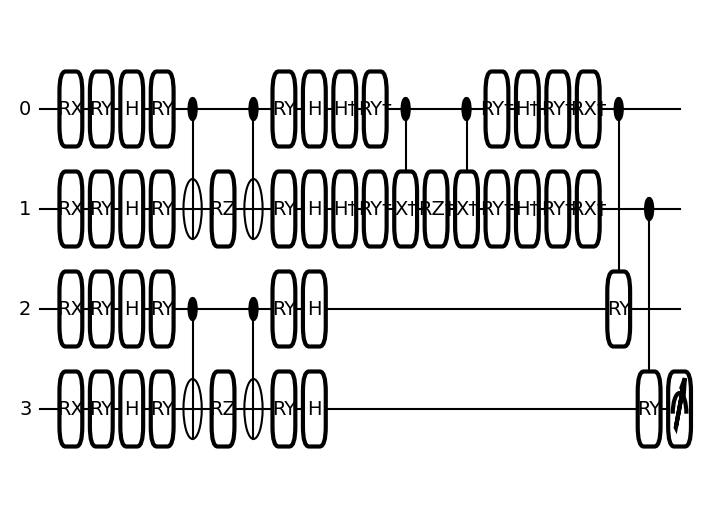

In [4]:
num_para = 5
#Block-encoding + Hardware-efficient Ansatz
def DataEncoding(x, wires_start, wires_end):
    wires = np.arange(wires_start, wires_end).tolist()
    qml.RX(x[0], wires=wires_start)
    qml.RX(x[1], wires=wires_start + 1)
    qml.RY(x[2], wires=wires_start)
    qml.RY(x[3], wires=wires_start + 1)
    #qml.AmplitudeEmbedding(features=x, wires=wires, pad_with=0., normalize=True)

def Ansatz(params, wires_start, wires_end):
    for i in np.arange(wires_start, wires_end):
        qml.Hadamard(wires=wires[i])
        qml.RY(params[i - wires_start], wires=wires[i])
    qml.CNOT(wires=[wires[wires_start], wires[wires_end - 1]])
    qml.RZ(params[wires_end - wires_start], wires=wires[wires_end - 1])
    qml.CNOT(wires=[wires_start, wires_end - 1])
    for i in np.arange(wires_start, wires_end):
        qml.RY(params[i + wires_end - 2 * wires_start], wires=wires[i])
        qml.Hadamard(wires=wires[i])

p = 0
#@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
@qml.qnode(dev)
def QKSAN(feat, params):
    x1 = feat[0:4]
    x2 = feat[4:8]
    DataEncoding(x1, 0, wire)
    Ansatz(params[0: num_para], 0, wire)
    qml.adjoint(Ansatz)(params[num_para: 2 * num_para], 0, wire)
    qml.adjoint(DataEncoding)(x2, 0, wire)


    DataEncoding(x2, wire, (2 * wire))
    Ansatz(params[2 * num_para: 3 * num_para], wire, (2 * wire))
    if p != 0:
        for i in range(2 * wire):
            qml.BitFlip(p, wires=i)
    for i in range(wire):
        qml.cond(qml.measure(i), qml.RY)(params[3 * num_para + i], wires=wires[i + wire])
    return qml.expval(qml.PauliZ(2 * wire - 1))

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(QKSAN, show_all_wires=True)(feats_train[0], params_init)
fig.set_size_inches((7, 5))

def variational_classifier(params, feat):
    return QKSAN(feat, params)


def cost(params, features, labels):
    predictions = [variational_classifier(params, feat) for feat in features]
    return square_loss(labels, predictions)

def TrainQKSAN(params_init):
    opt = qml.NesterovMomentumOptimizer(0.09)
    batch_size = 30
    weights = params_init
    #bias = np.array(0.0, requires_grad=True)
    his_acc_val = []
    his_acc_train = []
    his_cost = []
    f1_train = []
    f1_test = []
    roc_auc_train = []
    roc_auc_test = []
    for it in range(120):

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, 2 * train_size, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        
        weights, _, _ = opt.step(cost, weights, feats_train_batch, Y_train_batch)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(weights, feat)) for feat in feats_train]
        predictions_val = [np.sign(variational_classifier(weights, feat)) for feat in feats_val]
        #print(probs(Y_train, predictions_val))
        c = cost(weights, features, Y).numpy()
        #print(c)
        # Compute accuracy on train and validation set
        acc_train = accuracy_score(Y_train, predictions_train)
        acc_val = accuracy_score(Y_val, predictions_val)
        a = f1_score(Y_train, predictions_train)
        b = f1_score(Y_val, predictions_val)
        
        print("f1_score is", a, b)
        d = roc_auc_score(Y_train, predictions_train)
        e = roc_auc_score(Y_val, predictions_val)
        print("roc_auc_score is", d, e)


        f1_train.append(a)
        f1_test.append(b)
        roc_auc_train.append(d)
        roc_auc_test.append(e)
        his_acc_val.append(acc_val)
        his_acc_train.append(acc_train)
        his_cost.append(c)
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, c, acc_train, acc_val))
    print(p)
    return his_acc_val, his_acc_train, his_cost, f1_train, f1_test, roc_auc_train, roc_auc_test

In [5]:
ps = [0, 0.1, 0.2, 0.3]
his1 = []
his2 = []
his3 = []

for p in ps:
    his_acc_val, his_acc_train, his_cost, _, _, _, _ = TrainQKSAN(params_init)
    his1.append(his_acc_val)
    his2.append(his_acc_train)
    his3.append(his_cost)

f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     1 | Cost: 1.0840699 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     2 | Cost: 1.0689373 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     3 | Cost: 1.0503222 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     4 | Cost: 1.0307260 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     5 | Cost: 1.0096869 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_score is 0.5 0.5
Iter:     6 | Cost: 0.9879550 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.6666666666666666 0.6666666666666666
roc_auc_

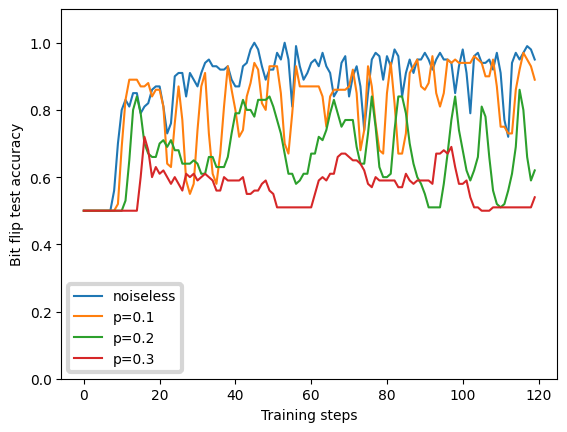

In [6]:
plt.plot([i for i in range(120)],his1[0], label = 'noiseless')
plt.plot([i for i in range(120)],his1[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his1[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his1[3], label = 'p=0.3')
plt.ylim((0, 1.1))
plt.xlabel('Training steps')
plt.ylabel('Bit flip test accuracy')
plt.legend()
plt.savefig('Angle_Encoding_QAOA_ansatz test accuracy1',dpi=600,bbox_inches='tight')
plt.show()

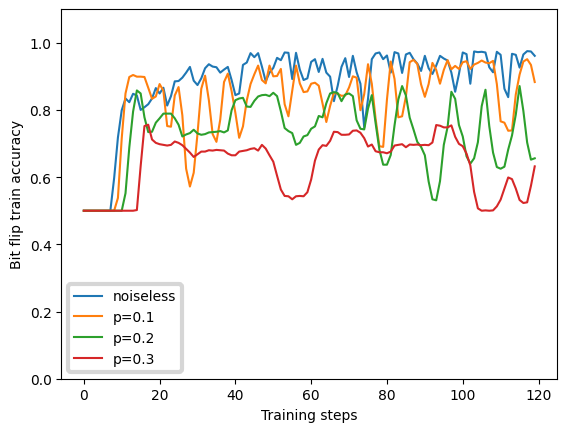

In [7]:
plt.plot([i for i in range(120)],his2[0], label = 'noiseless')
plt.plot([i for i in range(120)],his2[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his2[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his2[3], label = 'p=0.3')
plt.ylim((0, 1.1))
plt.xlabel('Training steps')
plt.ylabel('Bit flip train accuracy')
plt.legend()
plt.savefig('Angle_Encoding_QAOA_ansatz train accuracy1',dpi=600,bbox_inches='tight')
plt.show()

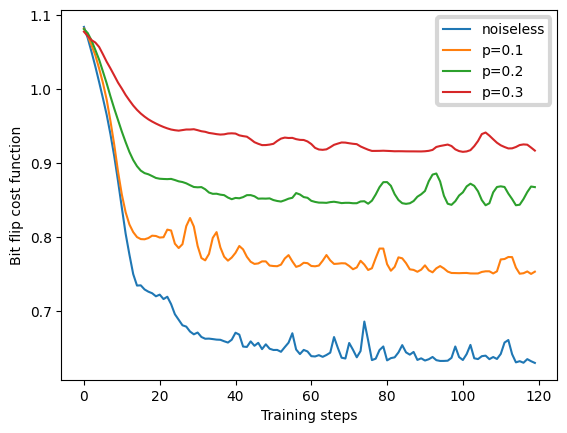

In [8]:
plt.plot([i for i in range(120)],his3[0], label = 'noiseless')
plt.plot([i for i in range(120)],his3[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his3[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his3[3], label = 'p=0.3')
#plt.ylim((0, 1.1))
plt.xlabel('Training steps')
plt.ylabel('Bit flip cost function')
plt.legend()
plt.savefig('Angle_Encoding_QAOA_ansatz cost function1',dpi=600,bbox_inches='tight')
plt.show()

In [9]:
print(his1)
print(his2)
print(his3)

[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.56, 0.7, 0.8, 0.83, 0.81, 0.85, 0.85, 0.79, 0.81, 0.82, 0.86, 0.87, 0.87, 0.81, 0.73, 0.76, 0.9, 0.91, 0.91, 0.84, 0.91, 0.89, 0.87, 0.91, 0.94, 0.95, 0.93, 0.93, 0.92, 0.92, 0.93, 0.89, 0.87, 0.87, 0.93, 0.94, 0.98, 1.0, 0.98, 0.93, 0.89, 0.92, 0.92, 0.97, 0.95, 1.0, 0.95, 0.81, 0.99, 0.93, 0.89, 0.91, 0.94, 0.95, 0.93, 0.97, 0.93, 0.91, 0.84, 0.86, 0.94, 0.96, 0.84, 0.9, 0.93, 0.87, 0.74, 0.85, 0.95, 0.97, 0.96, 0.89, 0.96, 0.93, 0.98, 0.96, 0.84, 0.91, 0.95, 0.91, 0.95, 0.95, 0.97, 0.95, 0.92, 0.95, 0.97, 0.95, 0.95, 0.94, 0.85, 0.93, 0.98, 0.91, 0.79, 0.96, 0.97, 0.94, 0.94, 0.95, 0.92, 0.97, 0.91, 0.77, 0.72, 0.94, 0.97, 0.95, 0.97, 0.99, 0.98, 0.95], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.52, 0.69, 0.83, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.84, 0.86, 0.86, 0.81, 0.64, 0.63, 0.76, 0.87, 0.77, 0.59, 0.55, 0.58, 0.74, 0.87, 0.91, 0.73, 0.61, 0.58, 0.67, 0.81, 0.93, 0.86, 0.8, 0.72, 0.74, 0.84, 0.88, 0.94, 0.92, 0.82, 0.8, 0.93, 0

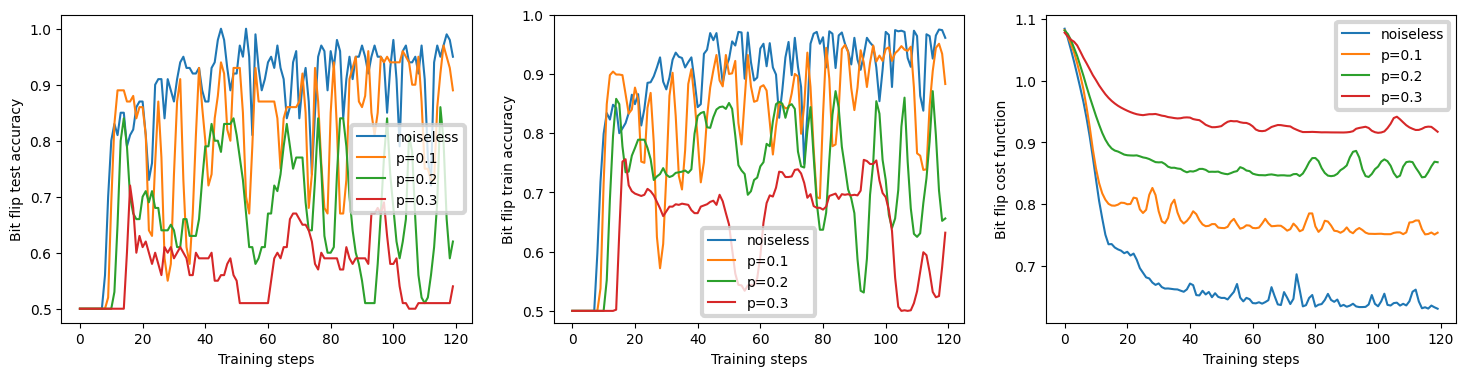

In [13]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)

plt.plot([i for i in range(120)],his1[0], label = 'noiseless')
plt.plot([i for i in range(120)],his1[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his1[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his1[3], label = 'p=0.3')
#plt.ylim((0, 1.1))
plt.xlabel('Training steps')
plt.ylabel('Bit flip test accuracy')
plt.legend()
#plt.title("plot 1")

plt.subplot(1, 3, 2)

plt.plot([i for i in range(120)],his2[0], label = 'noiseless')
plt.plot([i for i in range(120)],his2[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his2[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his2[3], label = 'p=0.3')
plt.ylim((0.48, 1.))
plt.xlabel('Training steps')
plt.ylabel('Bit flip train accuracy')
plt.legend()
#plt.title("plot 2")

plt.subplot(1, 3, 3)

plt.plot([i for i in range(120)],his3[0], label = 'noiseless')
plt.plot([i for i in range(120)],his3[1], label = 'p=0.1')
plt.plot([i for i in range(120)],his3[2], label = 'p=0.2')
plt.plot([i for i in range(120)],his3[3], label = 'p=0.3')
#plt.ylim((0, 1.1))
plt.xlabel('Training steps')
plt.ylabel('Bit flip cost function')
plt.legend()
#plt.title("plot 2")

#plt.suptitle("RUNOOB subplot Test")
plt.savefig('Angle_Encoding_QAOA_ansatz5',dpi=800,bbox_inches='tight')
plt.show()